# Logistic Regression

### Ahmed J. Zerouali (2021/08/17)

This notebook covers the material in Section 17 of the DSML Bootcamp. 

**Summary**

- This section does not focus on logistic regression per se, Portilla uses this model as a context to perform basic classification tasks, and spends most of the time on the cleaning of the data.

- The example used in this section is the Titanic survivors data set on Kaggle: https://www.kaggle.com/c/titanic. They've already split the data into training and test subsets.

- Mathematically speaking, logistic regression is a misnomer since it is still a linear regression. The "logistic" part comes from using the logistic function to output a *probability*. We discuss this in section 1.

- For classification tasks, the evaluation of performance is not the same as for prediction. Some of these evaluation methods are discussed in Section 14 of the course. Section 17 focuses on the *accuracy* quantifier (proportion of correct classifications on a population of samples), and introduces the *confusion* matrix associated to the accuracy. This matrix encodes the total number True Positives/Negatives obtained (diagonal), as well as the number of False Positives (Type I errors) and False Negatives (Type II errors). Such evaluation metrics are readily available in Scikit Learn.

- In the Titanic example, the objective is classify whether a given passenger has survived the disaster. Lecture 90 is about *exploratory data analysis*, where we visualize the data at hand to decide which features are relevant to the task and familiarize oneself with the data set. Lecture 91 is about *cleaning* the data. Here, we convert categorical data into integers and deal with missing data. Lastly, in Lecture 92, Portilla shows logistic regression is done with the Scikit library and presents some performance evalutaion functions therein.


## Contents

1) Logistic Regression Theory

2) Exploratory Data Analysis

3) Cleaning the Data

4) Logistic Regression with Scikit Learn

____________

## 1) Logistic Regression Theory

Suppose as usual that $\mathcal{X}\subset\mathbb{R}^d$ is the feature space. Logistic regression concerns binary classification, meaning that the labels take values in $\mathcal{Y}=\{\pm 1\}$. We assume here that for $\vec{x}\in\mathcal{X}$, the label $y$ is given by:

$$ y = \mathbb{I}_{\left[\tfrac{1}{2}, 1\right]}\left( h_\theta(\vec{x}) \right),$$

with:

$$ h_\theta(\vec{x}) =  \sigma(\langle \vec{w}, \vec{x}\rangle +b), $$

where $\mathbb{I}_A$ denotes the indicator function of $A\subset\mathbb{R}$, the parameters of the model are $\theta=(\vec{w},b)\in\mathbb{R}^{(d+1)}$, and where $\sigma:\mathbb{R}\to [0,1]$ denotes the sigmoid function:

$$\sigma(t)=\frac{1}{1+ \exp(-t)}.$$

As such, logistic regression still consists of learning a linear function $\vec{x}\mapsto \langle \vec{w}, \vec{x}\rangle +b$, then the sigmoid gives a probability of being in class 1 (or -1), and a decision threshold is used in the indicator function to give the value $y\in\{\pm 1\}$. This is discussed in section 9.3 of Shalev-Shwartz & Ben-David.

**Technical comments:**

- The hypothesis class still has $\Theta = \mathbb{R}^{(d+1)}$ as a parameter space, and is simply the precomposition of $\mathcal{H}_{\mathrm{reg}}$ with the sigmoid $\sigma:\mathbb{R}\to [0,1]$.

- For logistic regression, the loss function is given by: 

$$ l \left( h_\theta (\vec{x}) , y \right) = \log\left( 1+ \exp\left[ -y( \langle \vec{w}, \vec{x}\rangle +b) \right] \right). $$
The motivation for this choice is that we want $h_\theta (\vec{x})$ close to 1 for $y=1$ and close to 0 for $y=1$. With this loss function, $l \left( h_\theta (\vec{x}) , y \right)=-\log\left( h_\theta (\vec{x})\right)$ for $y=1$, while $l \left( h_\theta (\vec{x}) , y \right)=-\log\left(1- h_\theta (\vec{x})\right)$ for $y=-1$, and we see that the closer $h_\theta (\vec{x})$ is to its correct values, the smaller the loss is.

- The logistic loss function above is convex, and the ERM problem associated with it is finding:

$$\theta^\ast = \arg \min_{\theta\in \Theta}\left[\frac{1}{|\mathcal{S}|} \sum_{i=1}^{|\mathcal{S}|} l \left( h_\theta (\vec{x_i}) , y_i \right)\right].$$

- Shalev-Shwartz and Ben-David discuss algorithms for minimizing convex functions in Ch.12 and later. They also remark that this ERM problem is identical to finding the Maximum Likelihood Estimator treated in Ch.24.



____________

## 2) Exploratory Data Analysis


### a) Basics

Let's start with the imports, again we'll call Scikit Learn as needed. For now we'll mostly use:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# I'm still not sure about what this does exactly...
%matplotlib inline

* Load the data CSV files. These have already been split into training and testing sets.

In [3]:
df_titanic_trn = pd.read_csv("Titanic_train_Kaggle.csv")
df_titanic_tst = pd.read_csv("Titanic_test_Kaggle.csv")

* Execute the basics:

In [4]:
df_titanic_trn.tail()


PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

In [5]:
df_titanic_tst.tail()

PassengerId  Pclass                          Name     Sex   Age  SibSp  \
413         1305       3            Spector, Mr. Woolf    male   NaN      0   
414         1306       1  Oliva y Ocana, Dona. Fermina  female  39.0      0   
415         1307       3  Saether, Mr. Simon Sivertsen    male  38.5      0   
416         1308       3           Ware, Mr. Frederick    male   NaN      0   
417         1309       3      Peter, Master. Michael J    male   NaN      1   

     Parch              Ticket      Fare Cabin Embarked  
413      0           A.5. 3236    8.0500   NaN        S  
414      0            PC 17758  108.9000  C105        C  
415      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416      0              359309    8.0500   NaN        S  
417      1                2668   22.3583   NaN        C

In [6]:
df_titanic_trn.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [7]:
df_titanic_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df_titanic_tst.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

In [9]:
df_titanic_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### b) Some data exploration

It will be convenient to look at a couple of plots to understand how the age, sex and class features influenced the survival of passengers. Below, I'll color code the two data sets as follows: Training data has colormap/palette *cividis* while the training data has *YlOrRd*.

* As a first example, let's look at counts of survivors in terms of their secks:

<AxesSubplot:xlabel='Survived', ylabel='count'>

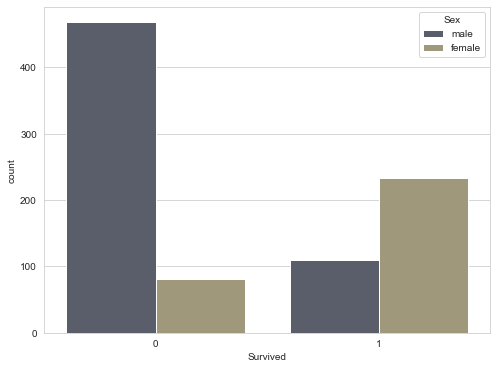

In [24]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
sns.countplot(x="Survived", data = df_titanic_trn, hue = "Sex", palette ="cividis")

We can't do the same with the test set, it doesn't have the "Survived" data.

* Next, we look at the counts with the Pclass hue:

<AxesSubplot:xlabel='Survived', ylabel='count'>

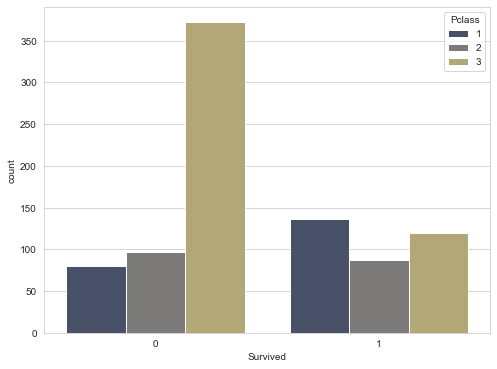

In [29]:
plt.figure(figsize=(8,6))
sns.countplot(x="Survived", data = df_titanic_trn, hue = "Pclass", palette ="cividis")


As one would expect: Most of the fatalities are (overwhelmingly) from the 3rd class, while most survivors were in first class.


### c) Visualizing missing data

Here we can use heatmaps to find where the null data lies in our data frames.

**Reminders:**

- Recall that data frames have the method ***pd_dataframe*.isnull()** that returns a Boolean data frame where the True values occur for missing data.

- Seaborn produces heatmaps from data frames with the **sns.heatmap(*data*)** function. Heatmaps of Numpy arrays are displayed using MatplotLib's **plt.imshow(*np_array*)**.

Now we have:

<AxesSubplot:>

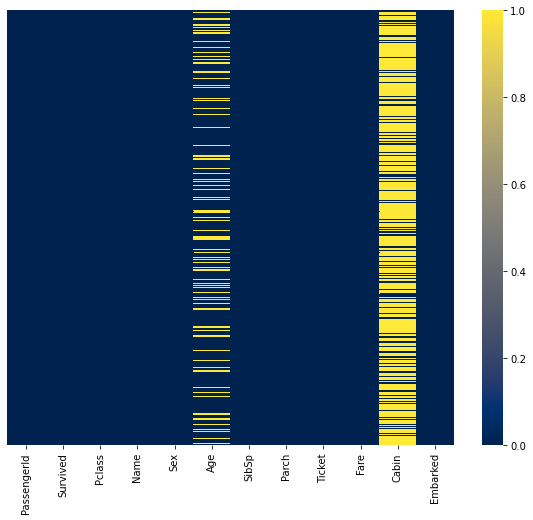

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(df_titanic_trn.isnull(),yticklabels = False,cmap = "cividis")

Colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html.

<AxesSubplot:>

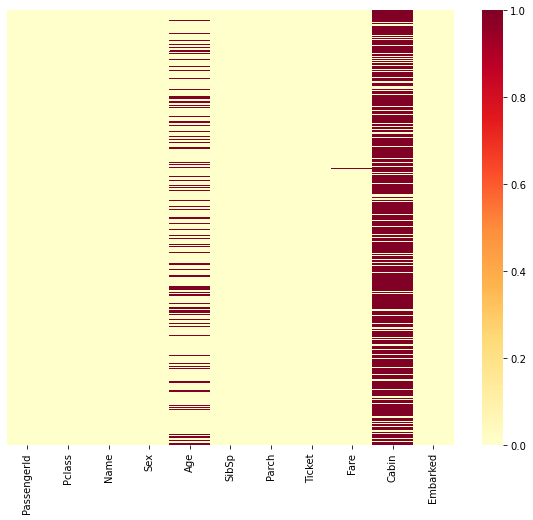

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(df_titanic_tst.isnull(), yticklabels = False, cmap = "YlOrRd")

* We will have to get rid of the missing values in the "Age" column. We will later drop the "Cabin" column since it's not a numerical value, and would hence be irrelevant for the regression task. Lastly, there is a missing value in the Fare column of the test set, which we'll also address.

____________

## 3) Cleaning the Data

Portilla just covers some basics of data cleaning in Lecture 91 (I don't know if he formalizes this more later in the course). In breif, cleaning means that we modify our dataset so that it is amenable to Scikit algorithms:

a) We get rid of irrelevant categorical data.

b) We fill-in missing data if possible, or supress the feature altogether.

c) We convert relevant categorical data into integer values

(See last 2 heat maps in previous section for reference.)

I'll first reload the data.

In [141]:
del df_titanic_trn
del df_titanic_tst

df_titanic_trn = pd.read_csv("Titanic_train_Kaggle.csv")
df_titanic_tst = pd.read_csv("Titanic_test_Kaggle.csv")

### a) Removing irrelevant features:

In [142]:
df_titanic_trn.tail()

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

In [143]:
df_titanic_trn["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

* We'll remove "PassengerId", "Ticket" and "Cabin". The latter has mostly missing values too, so this is the easy way of dealing with missing data.

In [144]:
df_titanic_trn = df_titanic_trn.drop(["PassengerId", "Ticket", "Cabin"], axis = 1)
df_titanic_trn

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch     Fare Embarked  
0      male  22.0      1      0   7.2500        S  
1    female  38.0      1      0  71.2833        C  
2    female  26.0      0      0   7.9250        S  
3    female  35.0      1      0  53.1000        S  
4      male  35.0      0      0   8.0500        S  
..      ...   ...    ...    ...      ...      ...  
886    male  27.0      0      0  13.0000        S  
887  female  19.0      0      0  30.0000        S  
888  female   NaN      1      2  23.4500        S  
889    male  26.0      0      0  30.0000        C  
890    male  32.0      0      0   7.7500        Q  

[891 rows x 9 columns]

<AxesSubplot:>

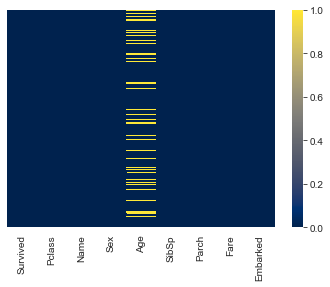

In [145]:
sns.heatmap(df_titanic_trn.isnull(),yticklabels = False,cmap = "cividis")

* Now we do the same for the test set:

In [146]:
df_titanic_tst = df_titanic_tst.drop(["PassengerId", "Ticket", "Cabin"], axis = 1)
df_titanic_tst 

Pclass                                          Name     Sex   Age  \
0         3                              Kelly, Mr. James    male  34.5   
1         3              Wilkes, Mrs. James (Ellen Needs)  female  47.0   
2         2                     Myles, Mr. Thomas Francis    male  62.0   
3         3                              Wirz, Mr. Albert    male  27.0   
4         3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0   
..      ...                                           ...     ...   ...   
413       3                            Spector, Mr. Woolf    male   NaN   
414       1                  Oliva y Ocana, Dona. Fermina  female  39.0   
415       3                  Saether, Mr. Simon Sivertsen    male  38.5   
416       3                           Ware, Mr. Frederick    male   NaN   
417       3                      Peter, Master. Michael J    male   NaN   

     SibSp  Parch      Fare Embarked  
0        0      0    7.8292        Q  
1        1      0    7.0000        S  
2        0      0    9.6875        Q  
3        0      0    8.6625        S  
4        1      1   12.2875        S  
..     ...    ...       ...      ...  
413      0      0    8.0500        S  
414      0      0  108.9000        C  
415      0      0    7.2500        S  
416      0      0    8.0500        S  
417      1      1   22.3583        C  

[418 rows x 8 columns]

* We'll also get rid of the names later when forming the X datasets for regression.

### b) Dealing with missing values:

* The nice example of missing data here is the age. Since it's a relevant feature in principle, we will **impute** the missing ages by replacing them with the average age by passenger class. Since we're dealing with a Pandas dataframe, this implies that we'll have to write a function that we'll pass as a parameter in the *.apply()* method.

* Portilla uses boxplots to estimate averages. I'll do something a little more sophisticated, and use only the averages from the training sets for imputation.

In [39]:
df_trn_age_cls = df_titanic_trn[["Age", "Pclass"]]
df_tst_age_cls = df_titanic_trn[["Age", "Pclass"]]

In [40]:
df_trn_age_cls[df_trn_age_cls["Pclass"]==1].mean()

Age       38.233441
Pclass     1.000000
dtype: float64

* Here is the list of average ages ordered by class. I had to work around the variable types since I only want floats.

In [51]:
avg_ages_cls = []

for i in range(3):
    mu = df_trn_age_cls[df_trn_age_cls["Pclass"]==(i+1)].mean()
    avg_ages_cls.append(mu.values[0])
    
avg_ages_cls

[38.233440860215055, 29.87763005780347, 25.14061971830986]

* Next we make the imputation function. This is tricky with Pandas.

**Comments:**
- Recall that by construction (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html?highlight=apply#pandas.DataFrame.apply), pd.DataFrame.apply(*func*) will apply *func* to every column of the dataframe by default (axis = 0), or to every row when **axis=1**. This means that the argument of *func* will be the dataframe on which it is applied. 
- It also seems that *func* must return something...
- For floats in a series, using series.isnull() is not appropriate, Python returns an error. Instead, one uses **pd.isnull(*series*)**.
- Recall that Pandas **does not do in-place** modifications by default. Instead of writing a function that modifies its input, make it **return** values and specify the columns to be modified before-hand.

In [128]:
# ***Important***: For later executions, make sure to run the avg_ages_cls loop in cell above.

def impute_age(in_series):
    # INPUT: Pandas series representing a row, must contain "Age" and "Pclass" labels (columns).
    # OUTPUT: Imputed "Age" as float64 if in_series["Age"]=nan, depending on class.
    
    # Age averages by Passenger class (local const, based on Titanic training set)
    avg_ages_cls = [38.233440860215055, 29.87763005780347, 25.14061971830986]
    
    # If "Age" nan
    if pd.isna(in_series["Age"]):
        if in_series["Pclass"] == 1:
            return avg_ages_cls[0]
        elif in_series["Pclass"] == 2:
            return avg_ages_cls[1]
        elif in_series["Pclass"] == 3:
            return avg_ages_cls[2]
    else:
        # Since assigning new values to "Age" column,
        # ensure original age is returned
        return in_series["Age"]

'''

THIS HERE DOESN'T WORK:

def impute_age(in_series):
    avg_ages_cls = [38.233440860215055, 29.87763005780347, 25.14061971830986]
    #if in_series["Age"].isnull():
    if pd.isna(in_series["Age"]):
        if in_series["Pclass"] == 1:
            in_series["Age"] = avg_ages_cls[0]
        elif in_series["Pclass"] == 2:
            in_series["Age"] = avg_ages_cls[1]
        elif in_series["Pclass"] == 3:
            in_series["Age"] = avg_ages_cls[2]
    

'''

'\n\nTHIS HERE DOESN\'T WORK:\n\ndef impute_age(in_series):\n    avg_ages_cls = [38.233440860215055, 29.87763005780347, 25.14061971830986]\n    #if in_series["Age"].isnull():\n    if pd.isna(in_series["Age"]):\n        if in_series["Pclass"] == 1:\n            in_series["Age"] = avg_ages_cls[0]\n        elif in_series["Pclass"] == 2:\n            in_series["Age"] = avg_ages_cls[1]\n        elif in_series["Pclass"] == 3:\n            in_series["Age"] = avg_ages_cls[2]\n    \n\n'

* Now we impute the training set:

In [147]:
df_titanic_trn["Age"] = df_titanic_trn[["Pclass", "Age"]].apply(impute_age, axis =1)

* Check that it worked:

<AxesSubplot:>

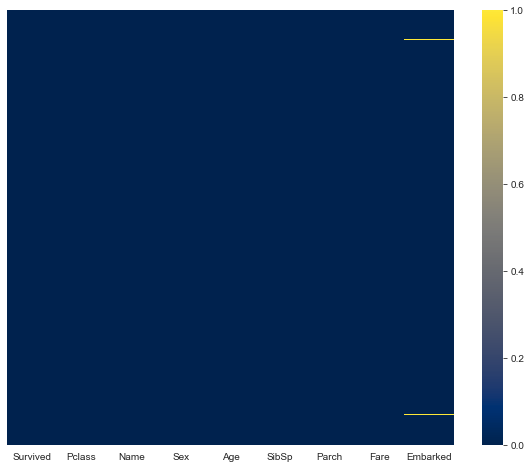

In [148]:
plt.figure(figsize=(10,8))
sns.heatmap(df_titanic_trn.isnull(),yticklabels = False,cmap = "cividis")

In [149]:
df_titanic_trn 

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex       Age  SibSp  Parch     Fare Embarked  
0      male  22.00000      1      0   7.2500        S  
1    female  38.00000      1      0  71.2833        C  
2    female  26.00000      0      0   7.9250        S  
3    female  35.00000      1      0  53.1000        S  
4      male  35.00000      0      0   8.0500        S  
..      ...       ...    ...    ...      ...      ...  
886    male  27.00000      0      0  13.0000        S  
887  female  19.00000      0      0  30.0000        S  
888  female  25.14062      1      2  23.4500        S  
889    male  26.00000      0      0  30.0000        C  
890    male  32.00000      0      0   7.7500        Q  

[891 rows x 9 columns]

* Now there only seem to be 2 missing values in the embarked column, and the already filled-out ages haven't been modified. 
* We do the same as above with the test set:

In [150]:
df_titanic_tst["Age"] = df_titanic_tst[["Pclass", "Age"]].apply(impute_age, axis =1)

<AxesSubplot:>

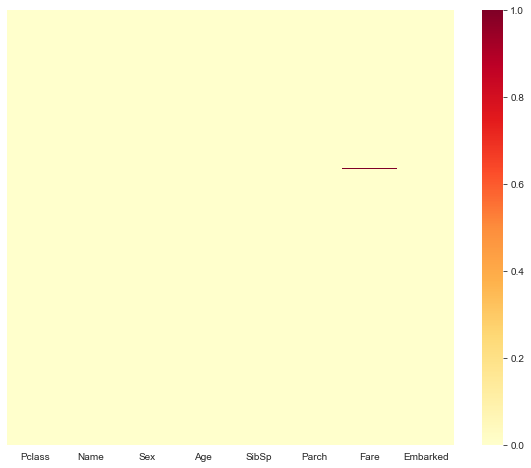

In [166]:
plt.figure(figsize=(10,8))
sns.heatmap(df_titanic_tst.isnull(),yticklabels = False,cmap = "YlOrRd")

In [152]:
df_titanic_tst

Pclass                                          Name     Sex       Age  \
0         3                              Kelly, Mr. James    male  34.50000   
1         3              Wilkes, Mrs. James (Ellen Needs)  female  47.00000   
2         2                     Myles, Mr. Thomas Francis    male  62.00000   
3         3                              Wirz, Mr. Albert    male  27.00000   
4         3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.00000   
..      ...                                           ...     ...       ...   
413       3                            Spector, Mr. Woolf    male  25.14062   
414       1                  Oliva y Ocana, Dona. Fermina  female  39.00000   
415       3                  Saether, Mr. Simon Sivertsen    male  38.50000   
416       3                           Ware, Mr. Frederick    male  25.14062   
417       3                      Peter, Master. Michael J    male  25.14062   

     SibSp  Parch      Fare Embarked  
0        0      0    7.8292        Q  
1        1      0    7.0000        S  
2        0      0    9.6875        Q  
3        0      0    8.6625        S  
4        1      1   12.2875        S  
..     ...    ...       ...      ...  
413      0      0    8.0500        S  
414      0      0  108.9000        C  
415      0      0    7.2500        S  
416      0      0    8.0500        S  
417      1      1   22.3583        C  

[418 rows x 8 columns]

* There seems to be one missing value in the "Fare" column for the test data.
* The easy way of dealing with these missing data is to just drop the corresponding rows. Of course, I'm not going to do that.

**Disgression starts here**

* Let's track down these missing values:

In [156]:
for row in range(len(df_titanic_trn)):
    if pd.isna(df_titanic_trn.iloc[row]["Embarked"]):
        print(f"Missing \"Embarked\" data in row {row}\n{df_titanic_trn.iloc[row]} \
            \n-------------------")
        
for row in range(len(df_titanic_tst)):
    if pd.isna(df_titanic_tst.iloc[row]["Fare"]):
        print(f"Missing \"Fare\" data in row {row}\n{df_titanic_trn.iloc[row]} \
            \n-------------------")

Missing "Embarked" data in row 61
Survived                      1
Pclass                        1
Name        Icard, Miss. Amelie
Sex                      female
Age                        38.0
SibSp                         0
Parch                         0
Fare                       80.0
Embarked                    NaN
Name: 61, dtype: object             
-------------------
Missing "Embarked" data in row 829
Survived                                            1
Pclass                                              1
Name        Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                            female
Age                                              62.0
SibSp                                               0
Parch                                               0
Fare                                             80.0
Embarked                                          NaN
Name: 829, dtype: object             
-------------------
Missing "Fare" data in row 152
Survived   

* For the missing "Embarked" entries in the training set, I'll try to assign random new values.

In [160]:
df_titanic_trn["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [163]:
rand_int = np.random.randint(low = 1, high =4, size=2)
rand_int

array([1, 3])

<ipython-input-164-0070c5121f5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titanic_trn.iloc[61]["Embarked"] = "S"
<ipython-input-164-0070c5121f5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titanic_trn.iloc[829]["Embarked"] = "Q"


<AxesSubplot:>

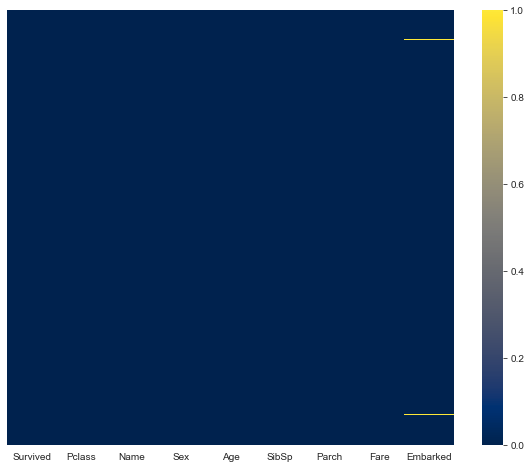

In [164]:
df_titanic_trn.iloc[61]["Embarked"] = "S"
df_titanic_trn.iloc[829]["Embarked"] = "Q"
plt.figure(figsize=(10,8))
sns.heatmap(df_titanic_trn.isnull(),yticklabels = False,cmap = "cividis")

**Disgression ends here**

* So Pandas doesn't let you modify entries easily. I'll drop the rows instead...

<AxesSubplot:>

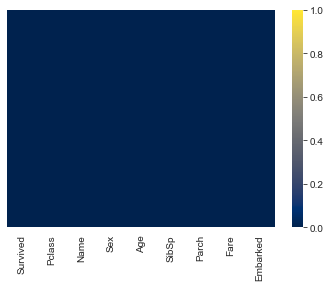

In [165]:
df_titanic_trn.drop(index=[61, 829])
sns.heatmap(df_titanic_trn.isnull(),yticklabels = False,cmap = "cividis")

<AxesSubplot:>

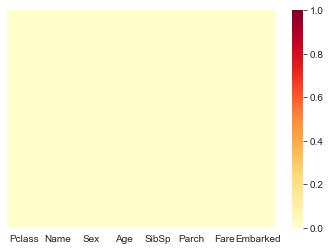

In [167]:
df_titanic_tst.drop(index=152)
sns.heatmap(df_titanic_tst.isnull(),yticklabels = False,cmap = "YlOrRd")

* Now we're good. We move on to replacing categorical values with integers.

### c) Converting categorical data to integers

Portilla discusses this part in Lecture 91, starting at 8:10. He does this with *dummy values*, with the **pd.get_dummies()** function

In [168]:
help(pd.get_dummies)

Help on function get_dummies in module pandas.core.reshape.reshape:

get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.
    
    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a dictionary mapping column names to prefixes.
    prefix_sep : str, default '_'
        If appending prefix, separator/delimiter to use. Or pass a
        list or dictionary as with `prefix`.
    dummy_na : bool, default False
        Add a column to indicate NaNs, if False NaNs are ignored.
    columns : list-like, default None
        Colu

* We convert male or female attributes in the "Sex" column by creating a new column with "male" only:

In [192]:
trn_sex = pd.get_dummies(df_titanic_trn["Sex"], drop_first=True)
tst_sex = pd.get_dummies(df_titanic_tst["Sex"], drop_first=True)

In [194]:
tst_sex

male
0       1
1       0
2       1
3       1
4       0
..    ...
413     1
414     0
415     1
416     1
417     1

[418 rows x 1 columns]

* Next, the "Embarked" column has 3 values with the counts
            S    644
            C    168
            Q     77
  Portilla drops one of those values, but I'll keep them all.

In [198]:
trn_emb = pd.get_dummies(df_titanic_trn["Embarked"])
tst_emb = pd.get_dummies(df_titanic_tst["Embarked"])

* Now we create the X_train, y_train and X_test data sets that will be used for logistic regression. We won't use the names, and instead of "Sex" and "Embarked", we'll append the dummy data frames above:


In [200]:
df_titanic_trn

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex       Age  SibSp  Parch     Fare Embarked  
0      male  22.00000      1      0   7.2500        S  
1    female  38.00000      1      0  71.2833        C  
2    female  26.00000      0      0   7.9250        S  
3    female  35.00000      1      0  53.1000        S  
4      male  35.00000      0      0   8.0500        S  
..      ...       ...    ...    ...      ...      ...  
886    male  27.00000      0      0  13.0000        S  
887  female  19.00000      0      0  30.0000        S  
888  female  25.14062      1      2  23.4500        S  
889    male  26.00000      0      0  30.0000        C  
890    male  32.00000      0      0   7.7500        Q  

[891 rows x 9 columns]

In [201]:
X_train = df_titanic_trn[["Pclass", "Age", "SibSp", "Parch", "Fare"]]
X_train = pd.concat([X_train, trn_sex, trn_emb], axis =1)

In [202]:
X_train 

Pclass       Age  SibSp  Parch     Fare  male  C  Q  S
0         3  22.00000      1      0   7.2500     1  0  0  1
1         1  38.00000      1      0  71.2833     0  1  0  0
2         3  26.00000      0      0   7.9250     0  0  0  1
3         1  35.00000      1      0  53.1000     0  0  0  1
4         3  35.00000      0      0   8.0500     1  0  0  1
..      ...       ...    ...    ...      ...   ... .. .. ..
886       2  27.00000      0      0  13.0000     1  0  0  1
887       1  19.00000      0      0  30.0000     0  0  0  1
888       3  25.14062      1      2  23.4500     0  0  0  1
889       1  26.00000      0      0  30.0000     1  1  0  0
890       3  32.00000      0      0   7.7500     1  0  1  0

[891 rows x 9 columns]

In [203]:
y_train = df_titanic_trn["Survived"]
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [204]:
df_titanic_tst

Pclass                                          Name     Sex       Age  \
0         3                              Kelly, Mr. James    male  34.50000   
1         3              Wilkes, Mrs. James (Ellen Needs)  female  47.00000   
2         2                     Myles, Mr. Thomas Francis    male  62.00000   
3         3                              Wirz, Mr. Albert    male  27.00000   
4         3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.00000   
..      ...                                           ...     ...       ...   
413       3                            Spector, Mr. Woolf    male  25.14062   
414       1                  Oliva y Ocana, Dona. Fermina  female  39.00000   
415       3                  Saether, Mr. Simon Sivertsen    male  38.50000   
416       3                           Ware, Mr. Frederick    male  25.14062   
417       3                      Peter, Master. Michael J    male  25.14062   

     SibSp  Parch      Fare Embarked  
0        0      0    7.8292        Q  
1        1      0    7.0000        S  
2        0      0    9.6875        Q  
3        0      0    8.6625        S  
4        1      1   12.2875        S  
..     ...    ...       ...      ...  
413      0      0    8.0500        S  
414      0      0  108.9000        C  
415      0      0    7.2500        S  
416      0      0    8.0500        S  
417      1      1   22.3583        C  

[418 rows x 8 columns]

In [205]:
X_test = df_titanic_tst[["Pclass", "Age", "SibSp", "Parch", "Fare"]]
X_test = pd.concat([X_test, tst_sex, tst_emb], axis =1)
X_test

Pclass       Age  SibSp  Parch      Fare  male  C  Q  S
0         3  34.50000      0      0    7.8292     1  0  1  0
1         3  47.00000      1      0    7.0000     0  0  0  1
2         2  62.00000      0      0    9.6875     1  0  1  0
3         3  27.00000      0      0    8.6625     1  0  0  1
4         3  22.00000      1      1   12.2875     0  0  0  1
..      ...       ...    ...    ...       ...   ... .. .. ..
413       3  25.14062      0      0    8.0500     1  0  0  1
414       1  39.00000      0      0  108.9000     0  1  0  0
415       3  38.50000      0      0    7.2500     1  0  0  1
416       3  25.14062      0      0    8.0500     1  0  0  1
417       3  25.14062      1      1   22.3583     1  1  0  0

[418 rows x 9 columns]

**Conclusion:** Cleaning the data is a long, tedious and technical process. This is essentially grunt-work...

________________

## 4) Logistic Regression with Scikit Learn

Portilla discusses logistic regression per se in Lecture 92. The general process is very similar to the linear regression lectures: We create a model object after importing the appropriate class from Scikit Learn; we use *.fit()* on the training data to train the model; next we use *.predict()* to do the regression; and finally, we evaluate the performance of the model. For evaluation, we'll import the **classification_report** function from **sklearn.metrics**. If we had the true survival values for the test set, we could also import **confusion_matrix** for comparison (which we do in the exercises).

**Comment:**

- I'm assuming that the data structures X_train, y_train and X_test from the previous section haven't been modified.

* Let's first import what we'll need from Scikit Learn:

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

**Step 1:** Instantiate a logistic regression model:

In [207]:
log_reg = LogisticRegression()

**Step 2:** Train the model with **.fit()**

In [211]:
log_reg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

With the features that I selected, this algorithm fails to converge. I'll remove the "Embarked" data then:

In [218]:
log_reg.fit(X_train.drop(labels = ["C","Q","S"], axis =1), y_train)

LogisticRegression()

**Step 3:** Classify the test data with **.predict()**:

In [222]:
# Somehow there's still an NaN in the test data:
X_test.iloc[152]

Pclass     3.0
Age       60.5
SibSp      0.0
Parch      0.0
Fare       NaN
male       1.0
C          0.0
Q          0.0
S          1.0
Name: 152, dtype: float64

In [225]:
X_test = X_test.drop(index =152)

<AxesSubplot:>

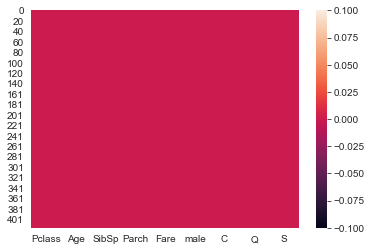

In [228]:

sns.heatmap(X_test.isnull())

In [227]:
y_pred = log_reg.predict(X_test.drop(labels = ["C","Q","S"], axis =1))

**Step 4:** Evaluate the model: Here we don't really have the true values, so we can't really evaluate the model. In the lectures, Portilla splits the training Kaggle data set into training and prediction. This makes for smaller data sets, which might explain why his training converged on the first try with the "Embarked" parameter.


**Comment:**
This is about the loss function used in Scikit's logistic regression algorithm. There is in fact an additional regularization term $\frac{1}{2}|\!|\vec{w}|\!|^2$ for numerical stability. Apparently, computer scientists include regularization terms more than statisticians in their algorithms. For more details, see:

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

________________

# Scrap:

### 3.b) Missing values

I'm testing the imputation function here

In [136]:
df_trn_scrap = pd.read_csv("Titanic_train_Kaggle.csv")

In [138]:
df_trn_scrap

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

<AxesSubplot:>

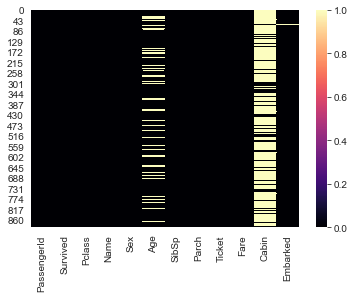

In [137]:
sns.heatmap(df_trn_scrap.isnull(), cmap="magma")

In [139]:
df_trn_scrap["Age"] = df_trn_scrap[["Pclass","Age"]].apply(impute_age, axis=1)

In [140]:
df_trn_scrap

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex       Age  \
0                              Braund, Mr. Owen Harris    male  22.00000   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.00000   
2                               Heikkinen, Miss. Laina  female  26.00000   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.00000   
4                             Allen, Mr. William Henry    male  35.00000   
..                                                 ...     ...       ...   
886                              Montvila, Rev. Juozas    male  27.00000   
887                       Graham, Miss. Margaret Edith  female  19.00000   
888           Johnston, Miss. Catherine Helen "Carrie"  female  25.14062   
889                              Behr, Mr. Karl Howell    male  26.00000   
890                                Dooley, Mr. Patrick    male  32.00000   

     SibSp  Parch            Ticket     Fare Cabin Embarked  
0        1      0         A/5 21171   7.2500   NaN        S  
1        1      0          PC 17599  71.2833   C85        C  
2        0      0  STON/O2. 3101282   7.9250   NaN        S  
3        1      0            113803  53.1000  C123        S  
4        0      0            373450   8.0500   NaN        S  
..     ...    ...               ...      ...   ...      ...  
886      0      0            211536  13.0000   NaN        S  
887      0      0            112053  30.0000   B42        S  
888      1      2        W./C. 6607  23.4500   NaN        S  
889      0      0            111369  30.0000  C148        C  
890      0      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

<AxesSubplot:>

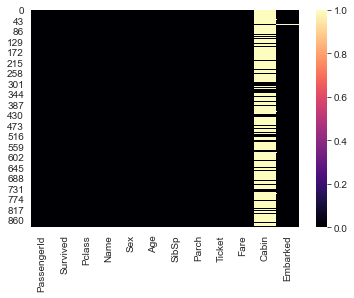

In [127]:
sns.heatmap(df_trn_scrap.isnull(), cmap="magma")

<AxesSubplot:>

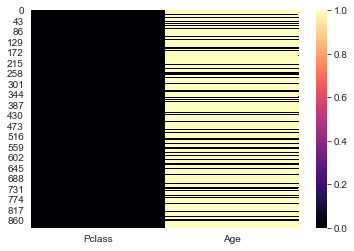

In [121]:
sns.heatmap(df_trn_scrap[["Pclass","Age"]].isnull(), cmap="magma")

In [84]:
df_trn_scrap.iloc[888]["Age"]

nan

In [89]:
pd.isna(df_trn_scrap.iloc[888]["Age"])

True

In [71]:
df_trn_scrap.iloc[0]

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object

In [72]:
df_trn_scrap.iloc[0]["Age"]

22.0

In [135]:
del df_trn_scrap

### 3.c) Categorical data

* First, execute the following cells

In [186]:
del df_trn_scrap

In [187]:
df_trn_scrap = pd.read_csv("Titanic_train_Kaggle.csv")

In [188]:
df_trn_scrap

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [189]:
df_trn_scrap = df_trn_scrap.drop(["PassengerId", "Ticket", "Cabin"], axis = 1)

In [190]:
df_trn_scrap

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch     Fare Embarked  
0      male  22.0      1      0   7.2500        S  
1    female  38.0      1      0  71.2833        C  
2    female  26.0      0      0   7.9250        S  
3    female  35.0      1      0  53.1000        S  
4      male  35.0      0      0   8.0500        S  
..      ...   ...    ...    ...      ...      ...  
886    male  27.0      0      0  13.0000        S  
887  female  19.0      0      0  30.0000        S  
888  female   NaN      1      2  23.4500        S  
889    male  26.0      0      0  30.0000        C  
890    male  32.0      0      0   7.7500        Q  

[891 rows x 9 columns]

In [191]:
sex = pd.get_dummies(df_trn_scrap["Sex"], drop_first=True)
sex

male
0       1
1       0
2       0
3       0
4       1
..    ...
886     1
887     0
888     0
889     1
890     1

[891 rows x 1 columns]

In [195]:
emb = pd.get_dummies(df_trn_scrap["Embarked"])

In [196]:
emb

C  Q  S
0    0  0  1
1    1  0  0
2    0  0  1
3    0  0  1
4    0  0  1
..  .. .. ..
886  0  0  1
887  0  0  1
888  0  0  1
889  1  0  0
890  0  1  0

[891 rows x 3 columns]